# Task 1: Data dimensionality, distance-based classifiers

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import umap

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fe7914d64c0>
Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 
2022-10-21 13:01:28.351515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 13:01:28.507143: W tensorflow/s

Reading the data

In [3]:
np.random.RandomState(1000)

train_in=np.genfromtxt('data/train_in.csv',delimiter=',')
train_out=np.genfromtxt('data/train_out.csv',delimiter=',')
test_in=np.genfromtxt('data/test_in.csv',delimiter=',')
test_out=np.genfromtxt('data/test_out.csv',delimiter=',')

## Calculating the center of the clouds for each digit

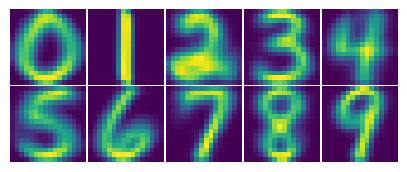

In [4]:
averages = np.zeros((10, 256))
count = np.zeros((10,1))
for i in range(len(train_in)):
    count[int(train_out[i])] += 1
    averages[int(train_out[i])] += train_in[i]

averages=averages/count

plt.figure(figsize=(5,2))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    ax.imshow(averages[i].reshape(16, 16))
plt.subplots_adjust(wspace=0.025, hspace=0)
plt.show()

Calculating the distance between the center of each cloud with each other <br>
$dist_{ij} = dist(c_i , c_j )$ for $i, j = 0, 1, ..,9$

In [5]:
differences=np.empty((10,10))
for i in range(10):
    for j in range(i,10):
        difference = np.linalg.norm(averages[i]-averages[j])
        differences[i,j]=difference
        differences[j,i]=difference

np.set_printoptions(formatter={'float': lambda x: "{: >4.1f}".format(x)})
print(differences)

[[ 0.0 14.4  9.3  9.1 10.8  7.5  8.2 11.9  9.9 11.5]
 [14.4  0.0 10.1 11.7 10.2 11.1 10.6 10.7 10.1  9.9]
 [ 9.3 10.1  0.0  8.2  7.9  7.9  7.3  8.9  7.1  8.9]
 [ 9.1 11.7  8.2  0.0  9.1  6.1  9.3  8.9  7.0  8.4]
 [10.8 10.2  7.9  9.1  0.0  8.0  8.8  7.6  7.4  6.0]
 [ 7.5 11.1  7.9  6.1  8.0  0.0  6.7  9.2  7.0  8.3]
 [ 8.2 10.6  7.3  9.3  8.8  6.7  0.0 10.9  8.6 10.4]
 [11.9 10.7  8.9  8.9  7.6  9.2 10.9  0.0  8.5  5.4]
 [ 9.9 10.1  7.1  7.0  7.4  7.0  8.6  8.5  0.0  6.4]
 [11.5  9.9  8.9  8.4  6.0  8.3 10.4  5.4  6.4  0.0]]


In [6]:
index_diff_pairs = []
for i in range(10):
    for j in range(i+1, 10):
        index_diff_pairs.append(((i, j), differences[i][j]))
result = sorted(index_diff_pairs, key=lambda x: x[1])
print("Pairs of indices (with point cloud center distance) sorted from hardest to separate to easiest to separate.")
print(*result , sep = "\n")

Pairs of indices (with point cloud center distance) sorted from hardest to separate to easiest to separate.
((7, 9), 5.426474119055888)
((4, 9), 6.0104079308959975)
((3, 5), 6.118750020921418)
((8, 9), 6.40116586858544)
((5, 6), 6.698691718889528)
((5, 8), 6.967386475240774)
((3, 8), 7.020424894700361)
((2, 8), 7.077516177863561)
((2, 6), 7.33180753932081)
((4, 8), 7.380908991053922)
((0, 5), 7.5192962595971835)
((4, 7), 7.583012282564445)
((2, 5), 7.906796320949824)
((2, 4), 7.932541482770051)
((4, 5), 8.001517414291124)
((0, 6), 8.154443125778972)
((2, 3), 8.17828488564782)
((5, 9), 8.258538068421224)
((3, 9), 8.354350120111869)
((7, 8), 8.467785300988439)
((6, 8), 8.587222275506706)
((4, 6), 8.78223264756089)
((2, 7), 8.872531069307183)
((2, 9), 8.887747852000189)
((3, 7), 8.922400934698304)
((3, 4), 9.087607799539475)
((0, 3), 9.143733671882783)
((5, 7), 9.211954024577228)
((3, 6), 9.302064730092098)
((0, 2), 9.334555870229643)
((0, 8), 9.90790173732039)
((1, 9), 9.932093699343712)

## Dimensionality Reduction Algorithms

In [7]:
# defining a function to handle the plotting

def plot_reduced(reduced_points, reduced_averages, labels, reduction_alg_name):
    # get a list of colors to use for plotting
    colors = list(mcolors.TABLEAU_COLORS)

    for i in range(10):
        points = reduced_points[np.where(labels == i)]
        plt.scatter(points[:,0], points[:,1], label=i, color=colors[i], s=10)
        # plot the average point for the current digit as a large point with black outline
        plt.scatter(reduced_averages[i,0], reduced_averages[i,1], color=colors[i], s=50, edgecolors='black', zorder=10)
    plt.title("2D visualization of {0}-reduced MNIST train data\n(cloud centers are large points with black outline)".format(reduction_alg_name))
    plt.legend(markerscale=2.5,fontsize=8)
    #plt.show()

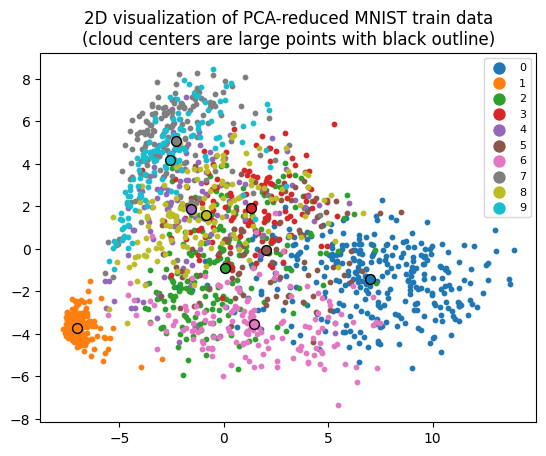

In [8]:
pca = PCA(n_components=2).fit(train_in)
reduced_pca = pca.transform(train_in)
reduced_averages_pca = pca.transform(averages)
plot_reduced(reduced_pca, reduced_averages_pca, train_out, "PCA")
plt.savefig('plots/pca.png')
plt.show()

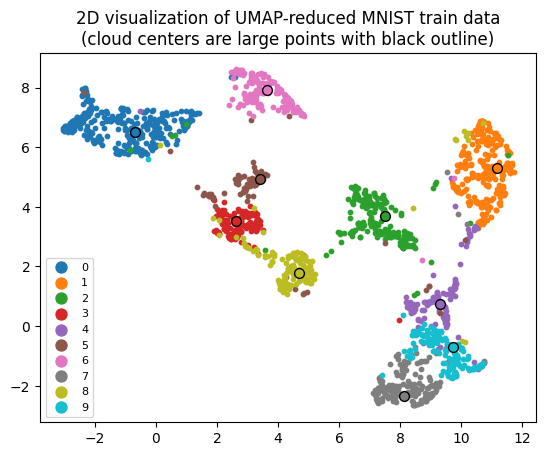

In [10]:
um = umap.UMAP()
um.fit(train_in)
reduced_umap = um.transform(train_in)
reduced_averages_umap = um.transform(averages)
plot_reduced(reduced_umap,reduced_averages_umap, train_out, "UMAP")
plt.savefig('plots/umap.png')
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


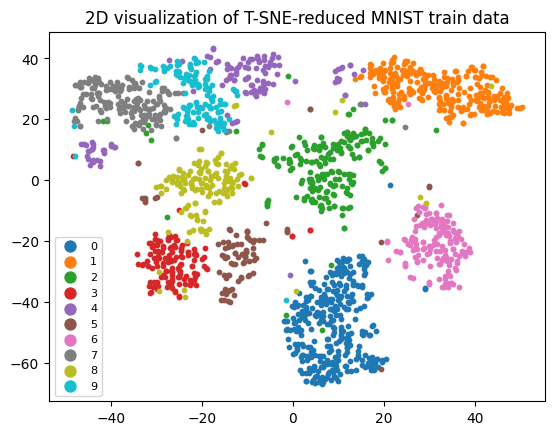

In [47]:
# Due to the way that the T-SNE algorithms works, there is no 'transform' function.
# This means that it is not possible to transform the centroids ('averages') by first fitting on the train data.
reduced_tsne = TSNE(n_components=2).fit_transform(train_in)

for i in range(10):
    points = reduced_tsne[np.where(train_out == i)]
    plt.scatter(points[:,0], points[:,1], label=i, s=10)
plt.title("2D visualization of T-SNE-reduced MNIST train data")
plt.legend(markerscale=2.5, scatterpoints=1, fontsize=8)
plt.savefig('plots/tsne.png')
plt.show()

## Applying the distance-based classifier 

### For the training dataset

In [11]:
predictions_train = []
for i in range(train_in.shape[0]):
    closest_digit = -1
    min_distance = float("inf")
    for digit in range(10):
        distance = np.linalg.norm(train_in[i] - averages[digit])
        if distance < min_distance:
            min_distance = distance
            closest_digit = digit
    predictions_train.append(closest_digit)

In [12]:
correct = 0
incorrect = 0
for i in range(len(train_out)):
    if predictions_train[i] == train_out[i]:
        correct += 1
    else:
        incorrect += 1

print("Performance of the distance-based classifier on the traing set")
print("Correct: " + str(correct))
print("Incorrect: " + str(incorrect))
print("Percentage: " + str(round(correct/(correct + incorrect)*100,3))+'%')

Performance of the distance-based classifier on the traing set
Correct: 1474
Incorrect: 233
Percentage: 86.35%


In [13]:
train_confusion_matrix=confusion_matrix(train_out, predictions_train)
print('The confusion matrix of the distance-based classifier for the training dataset')
print(train_confusion_matrix)

The confusion matrix of the distance-based classifier for the training dataset
[[271   0   0   0   2   4  36   0   6   0]
 [  0 252   0   0   0   0   0   0   0   0]
 [  3   0 167   9   9   1   3   4   6   0]
 [  0   0   2 120   1   3   0   1   3   1]
 [  0   8   1   0  95   0   3   0   0  15]
 [  3   0   2   3   4  67   3   1   2   3]
 [ 10   4   5   0   2   0 129   0   1   0]
 [  0   4   0   0   2   2   0 140   1  17]
 [  1   2   1  10   2   3   1   0 121   3]
 [  0   3   0   1  10   0   0   6   0 112]]


### For the testing dataset

In [14]:
predictions_test = []
for i in range(test_in.shape[0]):
    closest_digit = -1
    min_distance = float("inf")
    for digit in range(10):
        distance = np.linalg.norm(test_in[i] - averages[digit])
        if distance < min_distance:
            min_distance = distance
            closest_digit = digit
    predictions_test.append(closest_digit)


In [15]:
correct = 0
incorrect = 0
for i in range(len(test_out)):
    if predictions_test[i] == test_out[i]:
        correct += 1
    else:
        incorrect += 1

print("Performance of the distance-based classifier on the testing set")
print("Correct: " + str(correct))
print("Incorrect: " + str(incorrect))
print("Percentage: " + str(round(correct/(correct + incorrect)*100,3))+'%')

Performance of the distance-based classifier on the testing set
Correct: 804
Incorrect: 196
Percentage: 80.4%


In [16]:
test_confusion_matrix=confusion_matrix(test_out, predictions_test)
print('The confusion matrix of the distance-based classifier for the testing dataset')
print(test_confusion_matrix)

The confusion matrix of the distance-based classifier for the testing dataset
[[178   0   3   2   4   2  23   1  10   1]
 [  0 120   0   0   0   0   1   0   0   0]
 [  2   0  69   6   8   1   0   2  13   0]
 [  3   0   3  61   1   8   0   0   1   2]
 [  1   3   3   0  69   0   1   1   0   8]
 [  3   0   0   6   3  38   1   0   0   4]
 [  7   0   2   0   2   1  78   0   0   0]
 [  0   2   1   0   5   0   0  50   0   6]
 [  3   2   0   6   3   3   0   0  73   2]
 [  0   5   0   0   8   0   0   5   2  68]]


## Applying the KNN (K-Nearest-Neighbor) classifier

In [17]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_in, train_out)

KNeighborsClassifier(n_neighbors=3)

### For the training dataset

In [18]:
pred_train=neigh.predict(train_in)

In [19]:
correct = 0
incorrect = 0
for i in range(len(train_out)):
    if pred_train[i] == train_out[i]:
        correct += 1
    else:
        incorrect += 1

print("Performance of the KNN classifier on the training set")
print("Correct: " + str(correct))
print("Incorrect: " + str(incorrect))
print("Percentage: " + str(round(correct/(correct + incorrect)*100,3))+'%')

Performance of the KNN classifier on the training set
Correct: 1671
Incorrect: 36
Percentage: 97.891%


In [20]:
train_confusion_matrix_KNN=confusion_matrix(train_out, pred_train)
print('The confusion matrix of the KNN classifier for the training dataset')
print(train_confusion_matrix_KNN)

The confusion matrix of the KNN classifier for the training dataset
[[318   0   1   0   0   0   0   0   0   0]
 [  0 252   0   0   0   0   0   0   0   0]
 [  1   0 195   0   0   0   0   4   1   1]
 [  1   0   1 129   0   0   0   0   0   0]
 [  0   2   0   0 117   0   0   0   0   3]
 [  3   0   0   0   0  84   1   0   0   0]
 [  0   1   0   0   1   0 149   0   0   0]
 [  0   0   0   0   1   0   0 164   0   1]
 [  1   2   0   4   1   0   0   0 136   0]
 [  1   0   0   1   0   0   0   3   0 127]]


### For the testing dataset

In [21]:
pred_test=neigh.predict(test_in)

In [22]:
correct = 0
incorrect = 0
for i in range(len(test_out)):
    if pred_test[i] == test_out[i]:
        correct += 1
    else:
        incorrect += 1

print("Performance of the KNN classifier on the testing set")
print("Correct: " + str(correct))
print("Incorrect: " + str(incorrect))
print("Percentage: " + str(round(correct/(correct + incorrect)*100,3))+'%')

Performance of the KNN classifier on the testing set
Correct: 914
Incorrect: 86
Percentage: 91.4%


The confusion matrix of the KNN classifier for the training dataset
[[219   0   2   0   1   0   1   0   0   1]
 [  0 119   0   0   0   0   2   0   0   0]
 [  6   2  87   1   0   0   1   1   3   0]
 [  4   0   1  70   0   2   0   0   0   2]
 [  0   2   1   0  78   1   0   1   0   3]
 [  5   0   0   9   1  37   0   0   0   3]
 [  2   1   0   0   1   0  86   0   0   0]
 [  0   3   0   1   3   0   0  56   0   1]
 [  1   2   0   4   1   0   1   2  79   2]
 [  1   0   0   0   0   0   0   3   1  83]]


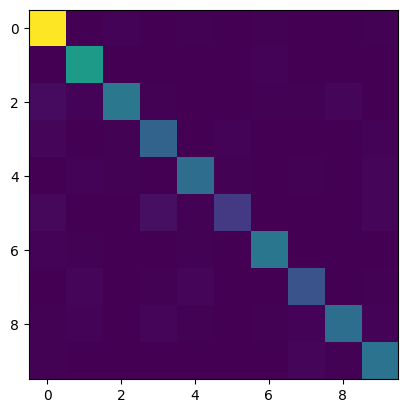

In [24]:
test_confusion_matrix_KNN=confusion_matrix(test_out, pred_test)
print('The confusion matrix of the KNN classifier for the training dataset')
print(test_confusion_matrix_KNN)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e562478f-16e9-4aa2-a205-fdebc346768a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>